In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='6'

import tensorflow as tf
from tensorflow.keras import layers, optimizers, models, datasets, regularizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import metrics as sk_metrics
from sklearn.model_selection import train_test_split

import scipy

from datetime import datetime

import PIL
from PIL import Image

In [2]:
plt.rcParams['figure.figsize'] = (8,5)
dataset_path = "/local/sandbox/DIODE_dataset/"

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [3]:
def ds_args(image):
    image = np.log(image)
    if image.shape[-1] == 1:
        image = np.squeeze(image, axis=-1)
    return image, {
        "cmap": "jet", # turbo doesn't exist in mpl 2.2.3
        "vmin": 0,
        "vmax": 3,
    }
    
def depthshow(image):
    args = ds_args(image)
    plt.imshow(args[0], **args[1])
    plt.axis("off")
    plt.show()

def imgrid(data, is_grid=False):
    print(data.shape)
    if not is_grid and data.shape[0] % 10 == 0:
        data = np.reshape(data, (-1, 10, *data.shape[1:]))
    if data.shape[-1] == 1:
        data = np.reshape(data, data.shape[:-1])
    print(data.shape)
    fig, ax = plt.subplots(data.shape[0], data.shape[1])
    fig.set_size_inches(data.shape[1], data.shape[0])
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            if data.shape[0] == 1:
                args = ds_args(data[y, x])
                ax[x].imshow(args[0], **args[1])
                ax[x].set_axis_off()
            else:
                args = ds_args(data[y, x])
                ax[y][x].imshow(args[0], **args[1])
                ax[y][x].set_axis_off()
    plt.show()
    
def display_images(rgb, pred, depth):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(4, 1)
    for i in range(3):
        ax[i].set_axis_off()
    ax[0].imshow(rgb)
    
    with np.errstate(divide='ignore'):
        args = ds_args(pred)
        ax[1].imshow(args[0], **args[1])

        args = ds_args(depth)
        ax[2].imshow(args[0], **args[1])
    plt.show()

In [4]:
all_data = np.load(dataset_path + "DIODE_dataset.npz")

# TODO: use outdoor or both
train_rgb = all_data["train_indoors_rgb"] / 255
train_depth = all_data["train_indoors_depth"]
train_depth_mask = all_data["train_indoors_depth_mask"].astype(int)
train_depth_mask = np.expand_dims(train_depth_mask, -1)
val_rgb = all_data["val_indoors_rgb"] / 255
val_depth = all_data["val_indoors_depth"]
val_depth_mask = all_data["val_indoors_depth_mask"].astype(int)
val_depth_mask = np.expand_dims(val_depth_mask, -1)

In [77]:
def interp_depths(depth, depth_mask):
    full_depth = np.zeros_like(depth)
    depth_mask_scan = np.zeros_like(depth_mask)
    
    middle = depth.shape[1] // 2
    depth = depth[:, middle, :, 0]
    depth_mask = depth_mask[:, middle, :, 0]
    depth_mask_scan[:, middle, :, 0] = depth_mask
    
    for i in range(depth.shape[0]):
        indices = np.arange(depth.shape[1])
        masked_depth = depth[i, depth_mask[i].astype(bool)]
        masked_indices = indices[depth_mask[i].astype(bool)]
        
        full_depth_fn = scipy.interpolate.interp1d(masked_indices, masked_depth, kind="linear", fill_value="extrapolate", assume_sorted=True)
        full_depth[i, middle, :, 0] = full_depth_fn(indices)
    
    return full_depth, depth_mask_scan

In [78]:
train_depth_scan, train_depth_mask_scan = interp_depths(train_depth, train_depth_mask)
val_depth_scan, val_depth_mask_scan = interp_depths(val_depth, val_depth_mask)

In [79]:
print(len(train_rgb), "train samples,", len(val_rgb), "val samples")
print(train_rgb[0].shape)
print(train_depth[0].shape)
print(train_depth_mask[0].shape)
image_shape = train_rgb[0].shape

train_gen = ImageDataGenerator().flow((train_rgb, [train_depth_scan, train_depth_mask_scan, train_depth, train_depth_mask]), train_depth, batch_size=32, shuffle=True)
val_gen = ImageDataGenerator().flow((val_rgb, [val_depth_scan, val_depth_mask_scan, val_depth, val_depth_mask]), val_depth, batch_size=32, shuffle=False)

8574 train samples, 325 val samples
(192, 256, 3)
(192, 256, 1)
(192, 256, 1)


In [83]:
reg = regularizers.l2(1e-5)

def conv_block(filters, strides=1, padding='same', sd=0.1):
    return [
        layers.Conv2D(filters, kernel_size=3, strides=strides, padding=padding, kernel_regularizer=reg, activity_regularizer=reg),
        layers.ReLU(),
        layers.SpatialDropout2D(sd),
        #layers.BatchNormalization(renorm=True),
    ]

def tconv_block(filters, strides=1, padding='same', sd=0.1):
    return [
        layers.Conv2DTranspose(filters, kernel_size=3, strides=strides, padding=padding, kernel_regularizer=reg, activity_regularizer=reg),
        layers.ReLU(),
        layers.SpatialDropout2D(sd),
        #layers.BatchNormalization(renorm=True),
    ]

def make_model():
    rgb_in = layers.Input(image_shape)
    depth_in = layers.Input(image_shape[:2] + (1,))
    depth_mask_in = layers.Input(image_shape[:2] + (1,))
    depth_scan_in = layers.Input(image_shape[:2] + (1,))
    depth_mask_scan_in = layers.Input(image_shape[:2] + (1,))
    
    x_depths = layers.Concatenate()([depth_scan_in, depth_mask_scan_in])
    x = layers.Concatenate()([rgb_in, depth_scan_in])
    
    depth_downscale_blocks = [
        [*conv_block(4)],
        [*conv_block(4, 2)],
        [*conv_block(8, 2)],
        [*conv_block(8, 2)],
        [*conv_block(16, 2)],
        [*conv_block(16, 2)],
    ]
    
    downscale_blocks = [
        [*conv_block(4),
         *conv_block(4)],
        [*conv_block(8, 2),
         *conv_block(8)],
        [*conv_block(16, 2),
         *conv_block(16)],
        [*conv_block(32, 2),
         *conv_block(32)],
        [*conv_block(64, 2),
         *conv_block(64)],
        [*conv_block(128, 2),
         *conv_block(128)],
    ]
    
    middle_blocks = [
        *conv_block(128, 2),
        *conv_block(128),
        *conv_block(128),
        *tconv_block(128, 2)
    ]
    
    upscale_blocks = [
        middle_blocks,
        [*conv_block(128),
         *tconv_block(64, 2)],
        [*conv_block(64),
         *tconv_block(32, 2)],
        [*conv_block(32),
         *tconv_block(16, 2)],
        [*conv_block(16),
         *tconv_block(8, 2)],
        [*conv_block(8),
         *tconv_block(4, 2)],
        [*conv_block(4)],
    ]
        
    downscale_x_depths = [x_depths]
    for block in depth_downscale_blocks:
        x_depths = models.Sequential(block)(downscale_x_depths[-1])
        downscale_x_depths += [x_depths]
    
    downscale_xs = [x]
    for blocks, downscale_x_depth in zip(downscale_blocks, downscale_x_depths):
        x = layers.Concatenate()([x, downscale_x_depth])
        x = models.Sequential(blocks)(downscale_xs[-1])
        downscale_xs += [x]
    
    for blocks, downscale_x, downscale_x_depth in zip(upscale_blocks, reversed(downscale_xs), reversed(downscale_x_depths)):
        x = models.Sequential(blocks)(x)
        x = layers.Concatenate()([x, downscale_x, downscale_x_depth])
    
    final_layers = models.Sequential([
        *conv_block(4),
        layers.Conv2D(1, kernel_size=3, padding="same"),
        layers.ReLU(),
    ])
    
    depth_preds = final_layers(x)
    
    model = models.Model([rgb_in, depth_scan_in, depth_mask_scan_in, depth_in, depth_mask_in], [depth_preds])
    model.summary()
    
    opt = optimizers.Adam(learning_rate=1e-3)
    loss = lambda y_true, y_pred: tf.math.reduce_mean(tf.math.square((tf.math.log(y_true + 1) - tf.math.log(y_pred + 1)) * depth_mask_in))
    metrics = []

    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    
    return model

In [84]:
tf.keras.backend.clear_session()

In [85]:
model = make_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 192, 256, 1) 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 192, 256, 4)  0           input_1[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 192, 256, 1) 0                                        

In [86]:
run_name = datetime.now().strftime("%Y%m%d-%H%M%S") + "-comp-unet-san"

class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        i = 0
        sample = model.predict([[val_rgb[i]], [val_depth_scan[i]], [val_depth_mask_scan[i]], [val_depth[i]], [val_depth_mask[i]]])
        display_images(val_rgb[i], sample[0], val_depth[i] * val_depth_mask[i])

tensorboard_cb = callbacks.TensorBoard(log_dir="./logs/" + run_name)

curr_epochs = 0

In [87]:
def run_epochs(epochs=100, lr_epoch=100):
    global curr_epochs
    cb = [
        callbacks.LearningRateScheduler(lambda e, l: l if (e + 1) % lr_epoch != 0 else l / 3, verbose=1),
        DisplayCallback(),
        tensorboard_cb,
    ]

    history = model.fit(
        train_gen,
        epochs=(epochs + curr_epochs),
        initial_epoch=curr_epochs,
        validation_data=val_gen,
        callbacks=cb,
    )
    
    curr_epochs += epochs

def display_samples():
    indices = [0, 100, 200, 300]
    samples = model.predict([train_rgb[indices], train_depth_scan[indices], train_depth_mask_scan[indices], train_depth[indices], train_depth_mask[indices]])
    i = 0

    for i in range(4):
        display_images(train_rgb[indices[i]], samples[i], train_depth[indices[i]] * train_depth_mask[indices[i]])

    indices = [0, 100, 200, 300]
    samples = model.predict([val_rgb[indices], val_depth_scan[indices], val_depth_mask_scan[indices], val_depth[indices], val_depth_mask[indices]])
    i = 0

    for i in range(4):
        display_images(val_rgb[indices[i]], samples[i], val_depth[indices[i]] * val_depth_mask[indices[i]])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 1.0316

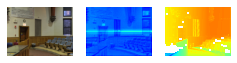

268/268 [==============================] - 80s 270ms/step - batch: 133.5000 - size: 31.9925 - loss: 1.0316 - val_loss: 0.5300

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.4757

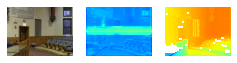

268/268 [==============================] - 71s 263ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.4757 - val_loss: 0.3891

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.3848

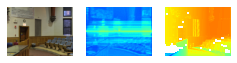

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.3848 - val_loss: 0.3374

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.3091

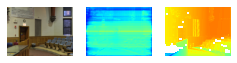

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.3091 - val_loss: 0.2792

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 5/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.2523

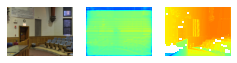

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.2523 - val_loss: 0.1925

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 6/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.2252

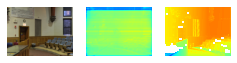

268/268 [==============================] - 70s 260ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.2252 - val_loss: 0.1716

Epoch 00007: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 7/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.2141

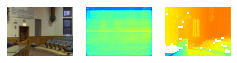

268/268 [==============================] - 70s 262ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.2141 - val_loss: 0.1809

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 8/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.2018

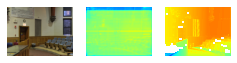

268/268 [==============================] - 69s 258ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.2018 - val_loss: 0.1618

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 9/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1945

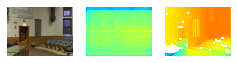

268/268 [==============================] - 69s 258ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1945 - val_loss: 0.1585

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 10/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1909

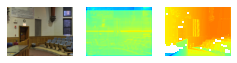

268/268 [==============================] - 70s 260ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1909 - val_loss: 0.1566

Epoch 00011: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 11/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1807

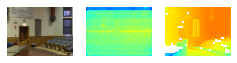

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1807 - val_loss: 0.1636

Epoch 00012: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 12/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1759

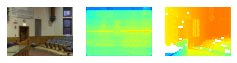

268/268 [==============================] - 70s 260ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1759 - val_loss: 0.1587

Epoch 00013: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 13/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1696

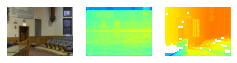

268/268 [==============================] - 69s 258ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1696 - val_loss: 0.1452

Epoch 00014: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 14/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1658

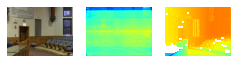

268/268 [==============================] - 70s 260ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1658 - val_loss: 0.1701

Epoch 00015: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 15/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1636

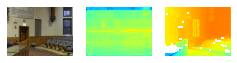

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1636 - val_loss: 0.1373

Epoch 00016: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 16/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1580

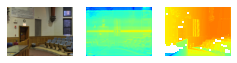

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1580 - val_loss: 0.1832

Epoch 00017: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 17/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1576

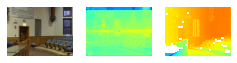

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1576 - val_loss: 0.1423

Epoch 00018: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 18/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1568

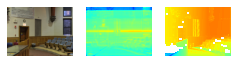

268/268 [==============================] - 69s 258ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1568 - val_loss: 0.1692

Epoch 00019: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 19/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1512

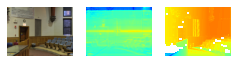

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1512 - val_loss: 0.1771

Epoch 00020: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 20/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1466

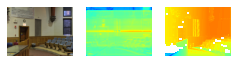

268/268 [==============================] - 70s 260ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1466 - val_loss: 0.1416

Epoch 00021: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 21/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1448

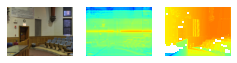

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1448 - val_loss: 0.1760

Epoch 00022: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 22/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1445

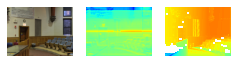

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1445 - val_loss: 0.1566

Epoch 00023: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 23/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1402

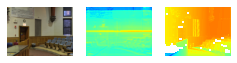

268/268 [==============================] - 70s 260ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1402 - val_loss: 0.1749

Epoch 00024: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 24/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1437

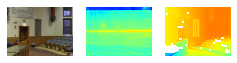

268/268 [==============================] - 69s 258ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1437 - val_loss: 0.1874

Epoch 00025: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 25/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1404

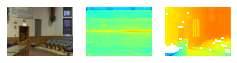

268/268 [==============================] - 69s 258ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1404 - val_loss: 0.1544

Epoch 00026: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 26/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1366

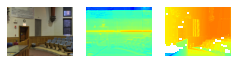

268/268 [==============================] - 70s 262ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1366 - val_loss: 0.1740

Epoch 00027: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 27/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1360

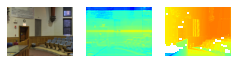

268/268 [==============================] - 69s 258ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1360 - val_loss: 0.1968

Epoch 00028: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 28/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1336

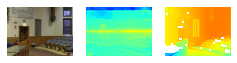

268/268 [==============================] - 69s 256ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1336 - val_loss: 0.1995

Epoch 00029: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 29/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1344

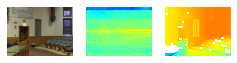

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1344 - val_loss: 0.1702

Epoch 00030: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 30/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1323

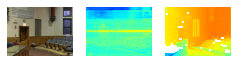

268/268 [==============================] - 69s 258ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1323 - val_loss: 0.2173

Epoch 00031: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 31/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1361

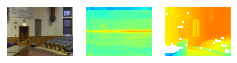

268/268 [==============================] - 69s 258ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1361 - val_loss: 0.1435

Epoch 00032: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 32/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1299

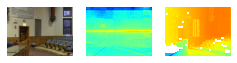

268/268 [==============================] - 69s 257ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1299 - val_loss: 0.2013

Epoch 00033: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 33/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1277

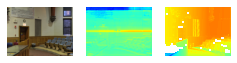

268/268 [==============================] - 69s 258ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1277 - val_loss: 0.2030

Epoch 00034: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 34/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1277

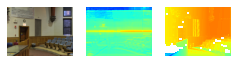

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1277 - val_loss: 0.1975

Epoch 00035: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 35/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1272

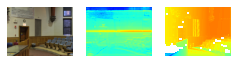

268/268 [==============================] - 71s 264ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1272 - val_loss: 0.2071

Epoch 00036: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 36/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1280

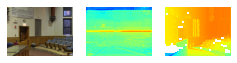

268/268 [==============================] - 70s 263ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1280 - val_loss: 0.1817

Epoch 00037: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 37/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1264

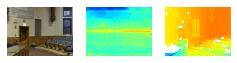

268/268 [==============================] - 70s 260ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1264 - val_loss: 0.1921

Epoch 00038: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 38/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1248

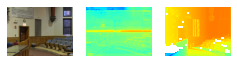

268/268 [==============================] - 70s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1248 - val_loss: 0.1620

Epoch 00039: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 39/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1278

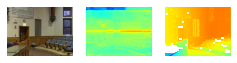

268/268 [==============================] - 70s 260ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1278 - val_loss: 0.1448

Epoch 00040: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 40/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1266

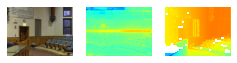

268/268 [==============================] - 69s 258ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1266 - val_loss: 0.1559

Epoch 00041: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 41/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1239

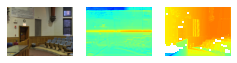

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1239 - val_loss: 0.1733

Epoch 00042: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 42/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1254

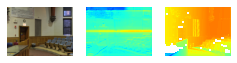

268/268 [==============================] - 70s 262ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1254 - val_loss: 0.1971

Epoch 00043: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 43/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1239

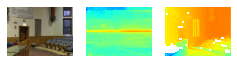

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1239 - val_loss: 0.1586

Epoch 00044: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 44/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1239

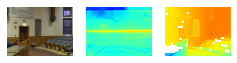

268/268 [==============================] - 69s 258ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1239 - val_loss: 0.2342

Epoch 00045: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 45/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1224

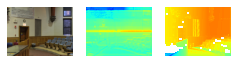

268/268 [==============================] - 70s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1224 - val_loss: 0.1774

Epoch 00046: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 46/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1228

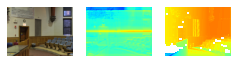

268/268 [==============================] - 70s 260ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1228 - val_loss: 0.1858

Epoch 00047: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 47/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1219

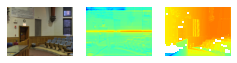

268/268 [==============================] - 71s 264ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1219 - val_loss: 0.1659

Epoch 00048: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 48/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1225

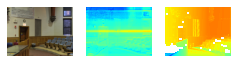

268/268 [==============================] - 70s 260ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1225 - val_loss: 0.2118

Epoch 00049: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 49/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1198

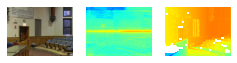

268/268 [==============================] - 70s 262ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1198 - val_loss: 0.1778

Epoch 00050: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 50/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1221

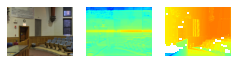

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1221 - val_loss: 0.1915

Epoch 00051: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 51/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1228

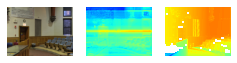

268/268 [==============================] - 70s 260ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1228 - val_loss: 0.2304

Epoch 00052: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 52/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1184

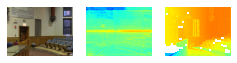

268/268 [==============================] - 71s 264ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1184 - val_loss: 0.1769

Epoch 00053: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 53/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1192

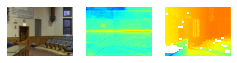

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1192 - val_loss: 0.1957

Epoch 00054: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 54/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1153

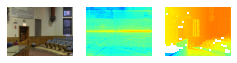

268/268 [==============================] - 70s 262ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1153 - val_loss: 0.1930

Epoch 00055: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 55/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1193

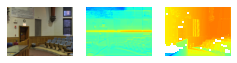

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1193 - val_loss: 0.1802

Epoch 00056: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 56/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1201

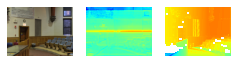

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1201 - val_loss: 0.1962

Epoch 00057: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 57/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1215

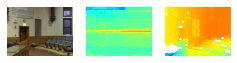

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1215 - val_loss: 0.1622

Epoch 00058: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 58/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1197

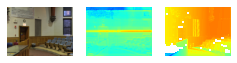

268/268 [==============================] - 70s 260ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1197 - val_loss: 0.1835

Epoch 00059: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 59/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1178

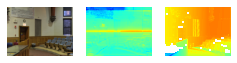

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1178 - val_loss: 0.1964

Epoch 00060: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 60/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1183

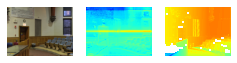

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1183 - val_loss: 0.2454

Epoch 00061: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 61/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1205

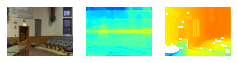

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1205 - val_loss: 0.2087

Epoch 00062: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 62/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1173

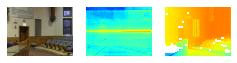

268/268 [==============================] - 70s 262ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1173 - val_loss: 0.2391

Epoch 00063: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 63/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1146

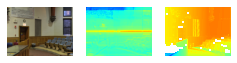

268/268 [==============================] - 69s 258ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1146 - val_loss: 0.1732

Epoch 00064: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 64/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1168

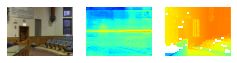

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1168 - val_loss: 0.2284

Epoch 00065: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 65/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1168

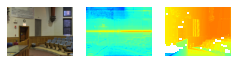

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1168 - val_loss: 0.2266

Epoch 00066: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 66/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1188

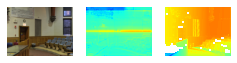

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1188 - val_loss: 0.2108

Epoch 00067: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 67/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1162

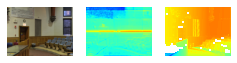

268/268 [==============================] - 70s 260ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1162 - val_loss: 0.2244

Epoch 00068: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 68/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1200

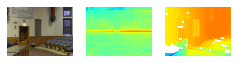

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1200 - val_loss: 0.1409

Epoch 00069: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 69/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1152

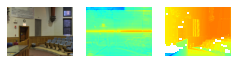

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1152 - val_loss: 0.1643

Epoch 00070: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 70/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1170

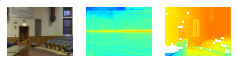

268/268 [==============================] - 70s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1170 - val_loss: 0.1997

Epoch 00071: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 71/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1149

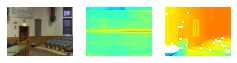

268/268 [==============================] - 69s 258ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1149 - val_loss: 0.1572

Epoch 00072: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 72/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1179

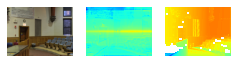

268/268 [==============================] - 69s 257ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1179 - val_loss: 0.1985

Epoch 00073: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 73/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1181

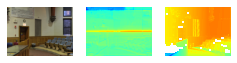

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1181 - val_loss: 0.1695

Epoch 00074: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 74/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1137

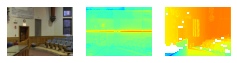

268/268 [==============================] - 70s 262ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1137 - val_loss: 0.1503

Epoch 00075: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 75/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1154

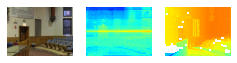

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1154 - val_loss: 0.2419

Epoch 00076: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 76/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1167

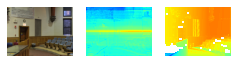

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1167 - val_loss: 0.2207

Epoch 00077: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 77/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1160

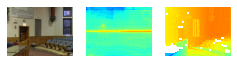

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1160 - val_loss: 0.1837

Epoch 00078: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 78/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1173

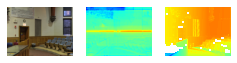

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1173 - val_loss: 0.2092

Epoch 00079: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 79/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1175

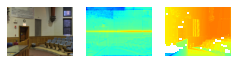

268/268 [==============================] - 70s 260ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1175 - val_loss: 0.2046

Epoch 00080: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 80/80
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1135

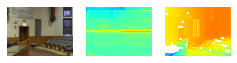

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1135 - val_loss: 0.1599


In [88]:
run_epochs(80)

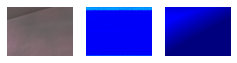

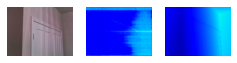

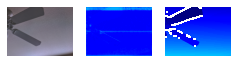

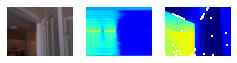

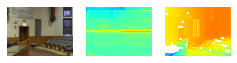

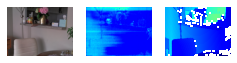

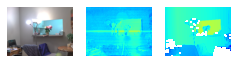

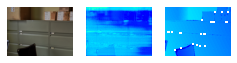

In [89]:
display_samples()


Epoch 00081: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 81/100
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1118

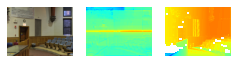

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1118 - val_loss: 0.1575

Epoch 00082: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 82/100
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1127

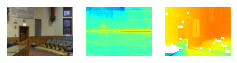

268/268 [==============================] - 70s 262ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1127 - val_loss: 0.1884

Epoch 00083: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 83/100
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1140

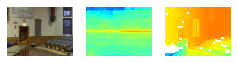

268/268 [==============================] - 70s 260ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1140 - val_loss: 0.1692

Epoch 00084: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 84/100
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1146

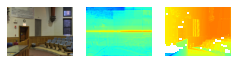

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1146 - val_loss: 0.1941

Epoch 00085: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 85/100
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1168

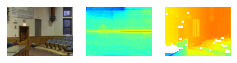

268/268 [==============================] - 70s 260ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1168 - val_loss: 0.1965

Epoch 00086: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 86/100
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1135

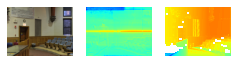

268/268 [==============================] - 69s 256ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1135 - val_loss: 0.1821

Epoch 00087: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 87/100
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1122

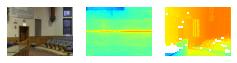

268/268 [==============================] - 70s 262ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1122 - val_loss: 0.1591

Epoch 00088: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 88/100
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1123

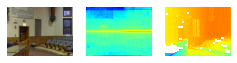

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1123 - val_loss: 0.2098

Epoch 00089: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 89/100
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1144

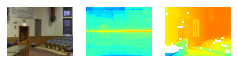

268/268 [==============================] - 70s 260ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1144 - val_loss: 0.2099

Epoch 00090: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 90/100
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1120

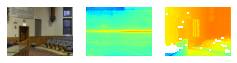

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1120 - val_loss: 0.1713

Epoch 00091: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 91/100
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1141

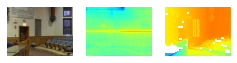

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1141 - val_loss: 0.1775

Epoch 00092: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 92/100
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1135

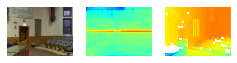

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1135 - val_loss: 0.1724

Epoch 00093: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 93/100
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1138

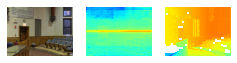

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1138 - val_loss: 0.1969

Epoch 00094: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 94/100
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1137

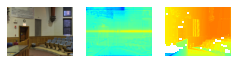

268/268 [==============================] - 70s 260ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1137 - val_loss: 0.2091

Epoch 00095: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 95/100
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1130

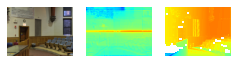

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1130 - val_loss: 0.1692

Epoch 00096: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 96/100
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1127

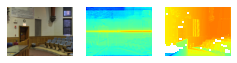

268/268 [==============================] - 69s 258ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1127 - val_loss: 0.2126

Epoch 00097: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 97/100
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1158

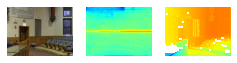

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1158 - val_loss: 0.1791

Epoch 00098: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 98/100
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1120

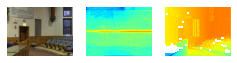

268/268 [==============================] - 69s 259ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1120 - val_loss: 0.1837

Epoch 00099: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 99/100
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1105

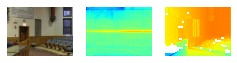

268/268 [==============================] - 69s 258ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1105 - val_loss: 0.1867

Epoch 00100: LearningRateScheduler reducing learning rate to 0.0003333333491658171.
Epoch 100/100
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.1045

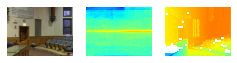

268/268 [==============================] - 70s 260ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.1045 - val_loss: 0.1868


In [90]:
run_epochs(20)

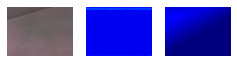

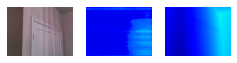

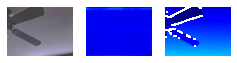

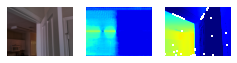

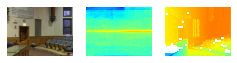

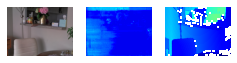

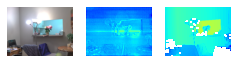

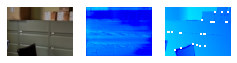

In [91]:
display_samples()


Epoch 00201: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 201/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0877

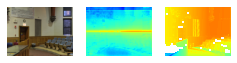

268/268 [==============================] - 72s 268ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0877 - val_loss: 0.2354

Epoch 00202: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 202/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0864

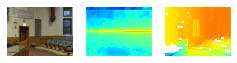

268/268 [==============================] - 72s 269ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0864 - val_loss: 0.2475

Epoch 00203: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 203/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0877

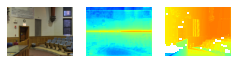

268/268 [==============================] - 71s 265ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0877 - val_loss: 0.2499

Epoch 00204: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 204/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0871

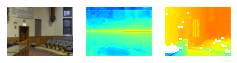

268/268 [==============================] - 71s 266ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0871 - val_loss: 0.2363

Epoch 00205: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 205/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0877

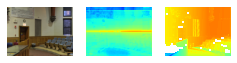

268/268 [==============================] - 72s 268ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0877 - val_loss: 0.2137

Epoch 00206: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 206/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0868

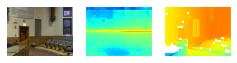

268/268 [==============================] - 71s 266ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0868 - val_loss: 0.2183

Epoch 00207: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 207/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0880

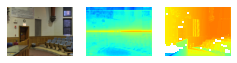

268/268 [==============================] - 71s 266ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0880 - val_loss: 0.2174

Epoch 00208: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 208/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0876

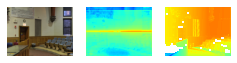

268/268 [==============================] - 72s 267ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0876 - val_loss: 0.2092

Epoch 00209: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 209/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0877

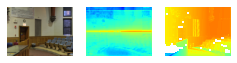

268/268 [==============================] - 71s 266ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0877 - val_loss: 0.2229

Epoch 00210: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 210/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0848

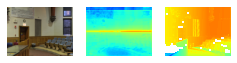

268/268 [==============================] - 72s 270ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0848 - val_loss: 0.2121

Epoch 00211: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 211/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0864

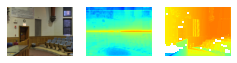

268/268 [==============================] - 70s 262ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0864 - val_loss: 0.2097

Epoch 00212: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 212/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0865

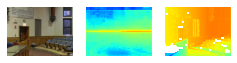

268/268 [==============================] - 73s 271ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0865 - val_loss: 0.2432

Epoch 00213: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 213/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0878

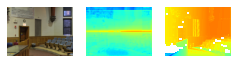

268/268 [==============================] - 72s 267ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0878 - val_loss: 0.1958

Epoch 00214: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 214/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0857

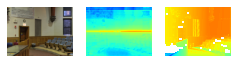

268/268 [==============================] - 72s 270ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0857 - val_loss: 0.2142

Epoch 00215: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 215/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0865

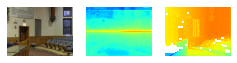

268/268 [==============================] - 72s 268ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0865 - val_loss: 0.2072

Epoch 00216: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 216/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0871

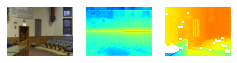

268/268 [==============================] - 72s 269ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0871 - val_loss: 0.2219

Epoch 00217: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 217/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0860

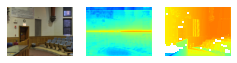

268/268 [==============================] - 72s 267ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0860 - val_loss: 0.2278

Epoch 00218: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 218/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0863

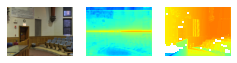

268/268 [==============================] - 72s 268ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0863 - val_loss: 0.2262

Epoch 00219: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 219/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0861

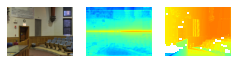

268/268 [==============================] - 72s 269ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0861 - val_loss: 0.2293

Epoch 00220: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 220/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0857

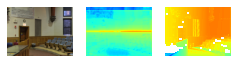

268/268 [==============================] - 72s 268ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0857 - val_loss: 0.1990

Epoch 00221: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 221/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0856

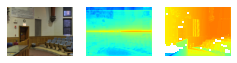

268/268 [==============================] - 73s 271ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0856 - val_loss: 0.2140

Epoch 00222: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 222/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0851

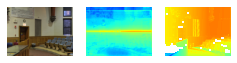

268/268 [==============================] - 72s 267ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0851 - val_loss: 0.2464

Epoch 00223: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 223/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0873

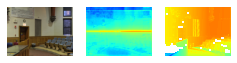

268/268 [==============================] - 73s 272ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0873 - val_loss: 0.2499

Epoch 00224: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 224/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0857

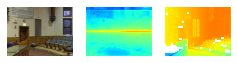

268/268 [==============================] - 71s 265ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0857 - val_loss: 0.2238

Epoch 00225: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 225/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0853

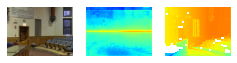

268/268 [==============================] - 72s 268ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0853 - val_loss: 0.2512

Epoch 00226: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 226/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0852

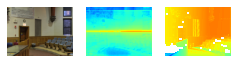

268/268 [==============================] - 71s 266ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0852 - val_loss: 0.2207

Epoch 00227: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 227/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0866

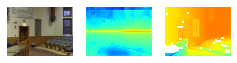

268/268 [==============================] - 72s 267ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0866 - val_loss: 0.2397

Epoch 00228: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 228/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0857

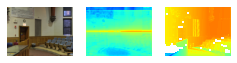

268/268 [==============================] - 71s 265ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0857 - val_loss: 0.2109

Epoch 00229: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 229/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0841

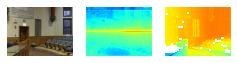

268/268 [==============================] - 72s 267ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0841 - val_loss: 0.2126

Epoch 00230: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 230/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0857

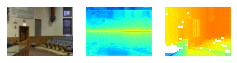

268/268 [==============================] - 71s 266ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0857 - val_loss: 0.2382

Epoch 00231: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 231/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0857

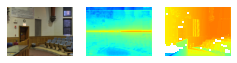

268/268 [==============================] - 71s 264ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0857 - val_loss: 0.2263

Epoch 00232: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 232/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0853

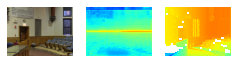

268/268 [==============================] - 72s 268ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0853 - val_loss: 0.2379

Epoch 00233: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 233/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0862

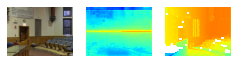

268/268 [==============================] - 71s 266ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0862 - val_loss: 0.2534

Epoch 00234: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 234/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0854

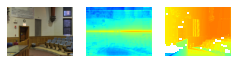

268/268 [==============================] - 72s 268ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0854 - val_loss: 0.2504

Epoch 00235: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 235/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0839

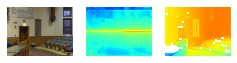

268/268 [==============================] - 71s 266ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0839 - val_loss: 0.2434

Epoch 00236: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 236/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0858

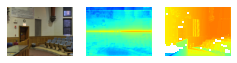

268/268 [==============================] - 72s 267ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0858 - val_loss: 0.2512

Epoch 00237: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 237/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0854

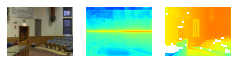

268/268 [==============================] - 72s 269ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0854 - val_loss: 0.2369

Epoch 00238: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 238/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0857

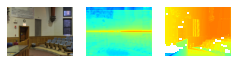

268/268 [==============================] - 70s 262ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0857 - val_loss: 0.1979

Epoch 00239: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 239/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0837

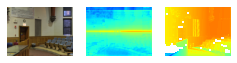

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0837 - val_loss: 0.2304

Epoch 00240: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 240/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0851

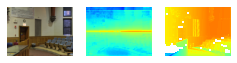

268/268 [==============================] - 70s 263ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0851 - val_loss: 0.2241

Epoch 00241: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 241/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0861

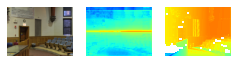

268/268 [==============================] - 70s 263ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0861 - val_loss: 0.2297

Epoch 00242: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 242/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0843

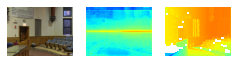

268/268 [==============================] - 70s 262ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0843 - val_loss: 0.2361

Epoch 00243: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 243/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0847

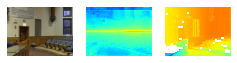

268/268 [==============================] - 70s 263ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0847 - val_loss: 0.2303

Epoch 00244: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 244/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0845

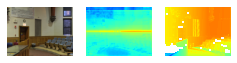

268/268 [==============================] - 71s 266ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0845 - val_loss: 0.2218

Epoch 00245: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 245/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0842

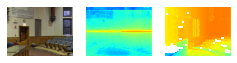

268/268 [==============================] - 71s 263ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0842 - val_loss: 0.2088

Epoch 00246: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 246/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0858

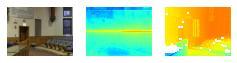

268/268 [==============================] - 70s 260ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0858 - val_loss: 0.2147

Epoch 00247: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 247/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0850

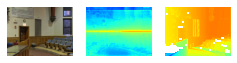

268/268 [==============================] - 71s 266ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0850 - val_loss: 0.2464

Epoch 00248: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 248/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0845

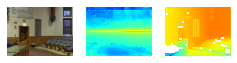

268/268 [==============================] - 70s 261ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0845 - val_loss: 0.2579

Epoch 00249: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 249/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0844

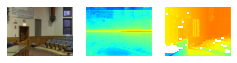

268/268 [==============================] - 72s 267ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0844 - val_loss: 0.2269

Epoch 00250: LearningRateScheduler reducing learning rate to 0.00011111111962236464.
Epoch 250/250
268/268 [==============================] - ETA: 0s - batch: 133.5000 - size: 31.9925 - loss: 0.0841

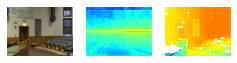

268/268 [==============================] - 71s 264ms/step - batch: 133.5000 - size: 31.9925 - loss: 0.0841 - val_loss: 0.2447


In [73]:
run_epochs(50)

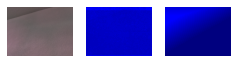

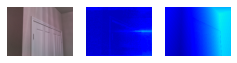

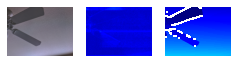

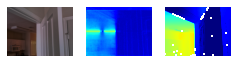

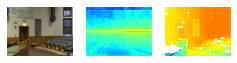

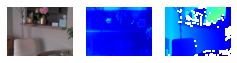

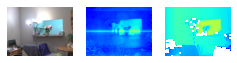

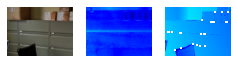

In [74]:
display_samples()